# Investigating No-Show Doctor Appointments in Brazil

In this project, I explore the 'No-show appointments' dataset from Kaggle. It contains ~110K records of medical appointments in Brazil, with a result variable of whether a patient shows up to his/her scheduled appointment.

### Questions Explored:
1. Does the patient's gender impact whether they show up to the appointment?
2. Does the time period between the scheduling day and appointment day matter? In other words, if you plan your appointment further in advance, are you more likely to show up (as opposed to schedulin more last minute and closer to day of actual appointment)?
3. Does the patient's association with the Welfare program Bolsa Familia play a role in appointment attendance?

### Data Changes: 
The ScheduledDay and AppointmentDay columns were transformed to a datetime datatype. This allowed me to calculate the time frame between day the appointment is scheduled and actual day of the appointment. This column is called "WaitPeriod"

In [22]:
#Importing Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime

%matplotlib inline

In [23]:
#Import Data and Exploration

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

#Data Exploration
df.head()
df.shape
df.describe()
df.nunique()
df.dtypes #looks good, might need to change patient id to string (object)
df.isnull().sum() #No nulls

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

#### Looking at Spread of Age
Interesting to see an outlier at around 118 years of age.
The mean value of 37.1 is very close to the medium value 37, so data is normally distributed. 

Next, I'll look at how the shape/distribution changes when we only look at data for no-shows.

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64


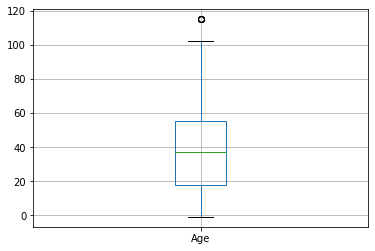

In [3]:
print(df['Age'].describe())
df.boxplot('Age');

Based on the data below, looks like the average age of No-show patients is about 4 years younger than the average age of the total dataset. The mean and median are still relatively close, with a **slight** right skew. 

This lower average age leads me to think that younger(middle-aged) people are more likely to be a no-show.

count    22319.000000
mean        34.317667
std         21.965941
min          0.000000
25%         16.000000
50%         33.000000
75%         51.000000
max        115.000000
Name: Age, dtype: float64


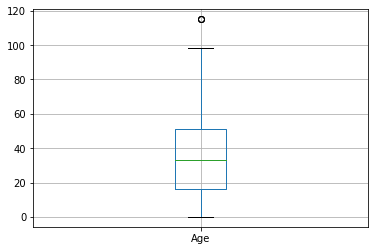

In [4]:
df_age = df[df['No-show'] == 'Yes']

print(df_age['Age'].describe())
df_age.boxplot('Age');

#### Correlation Matrix 
Age and Hipertension are positively correlated - the relationship between these two variables is strongest out of all other pairings.  

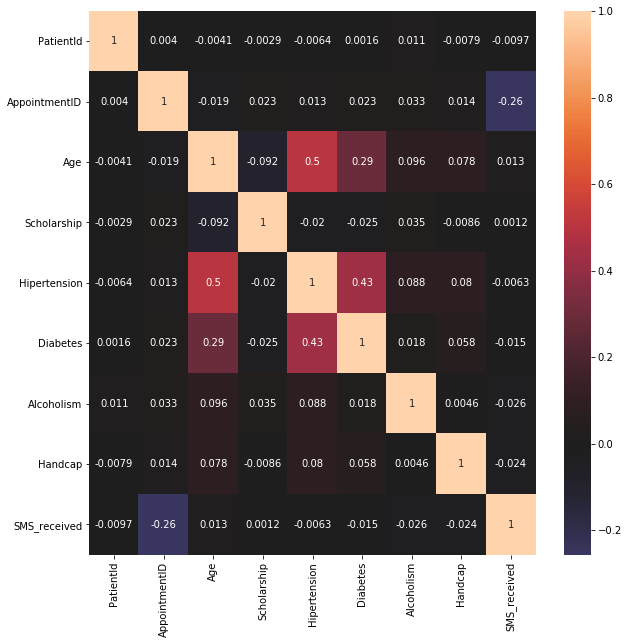

In [34]:
matrix = df.corr()

fig,ax = plt.subplots(figsize=(10,10))
ax = sn.heatmap(matrix, annot=True, center=0)
plt.show()

### Q1 - Investigate No-Shows by Gender
To investigate, I created two subsets of data segmented by "M" and "F" values in the `Gender` column. I then calculated proportions of no-shows/shows for each genders. 

According to the bar plot, both genders have a no-show rate of ~20%. This compels me to hypothesize that gender does **not** play a role in determinings no-shows.

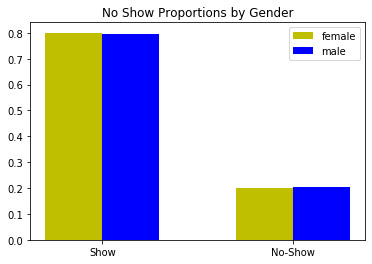

In [6]:
female = df.query('Gender == "F"')
male = df.query('Gender == "M"')

totals = df.groupby('Gender')['PatientId'].count()
#print(totals)

m_noshow = male['No-show'].value_counts() 
f_noshow = female['No-show'].value_counts()

m_proportions = m_noshow / totals['M']
f_proportions = f_noshow / totals['F']
#print(m_proportions)
#print(f_proportions)

#Lables for visuals
x_labels = ['Show', 'No-Show']
ind = np.arange(len(x_labels))
width = 0.3

f_bar = plt.bar(x = ind, height = m_proportions, width=width, color = 'y', label = 'female')
m_bar = plt.bar(x = ind+width, height= f_proportions, width=width, color = 'b', label = 'male')
plt.title('No Show Proportions by Gender')
plt.xticks(ind+ width / 2 , x_labels)
plt.legend()

plt.show()


### Q2 - Looking at Schedule-to-Appointment Time Frame
Next, I analyzed the time frame between when a person schedules the appointment and the actual day of the appointment. 

After converting to datetime datatype for the corresponding columns, I created a new column with the time difference, called `Wait Period`. I Then split sub-setted data in 2 groups: one where the patient's wait period is below average, and the other where wait period is above average. The longer the wait Period, the more in advance the appointment is scheduled. 

Based on the the bar chart, it **does** make a difference when the appointment is scheduled in relation to how far away the appointment is. Those who made appointments "last minute" were more likely to not show up. 

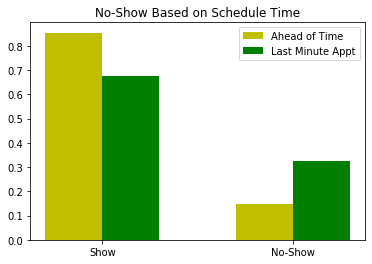

In [7]:
##Converting cols to datetime
datetime_cols = ['AppointmentDay', 'ScheduledDay']

def date_converter(col_names):
    for col in col_names:
        pd.to_datetime(df[col])
    


df['WaitPeriod'] = df['AppointmentDay'] - df['ScheduledDay']


WaitPeriodMean = df['WaitPeriod'].mean()
early_bird = df[df['WaitPeriod'] < WaitPeriodMean]
last_min = df[df['WaitPeriod'] >= WaitPeriodMean]


eb_proportions = early_bird['No-show'].value_counts() / early_bird['PatientId'].count()
lm_proportions = last_min['No-show'].value_counts() / last_min['PatientId'].count()


plt.bar(x = ind, height=eb_proportions, width=width, color='y', label = 'Ahead of Time');
plt.bar(x = ind+width,height=lm_proportions, width=width, color = 'g', label = 'Last Minute Appt');
plt.legend();
plt.title('No-Show Based on Schedule Time');
plt.xticks(ind+width/2, x_labels);




### Q3
Lastly, I investigated no-shows based on a patient's affiliation to the welfare program. 

**Those who are enrolled show higher proportions of no-shows.** 23.7% of enrolled patients do not show up, compared to 19.8% of non-enrolled patients who don't show up. 

In [8]:
totals_scholar = df['Scholarship'].value_counts()
by_scholar = df.groupby('Scholarship')['No-show'].value_counts()
no_welfare= (by_scholar[0] / totals_scholar[0])
welfare = (by_scholar[1]/ totals_scholar[1])
no_show_proportions = [no_welfare[1], welfare[1]]
#print(no_show_proportions)

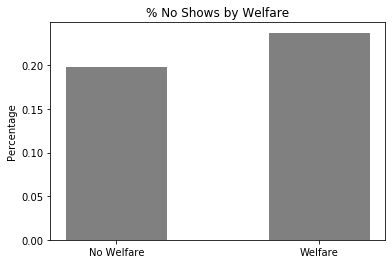

In [9]:
plt.bar(x=[1,2], height= no_show_proportions, width=0.5, color='gray');
plt.title('% No Shows by Welfare');
plt.xticks([1,2], ['No Welfare', 'Welfare']);
plt.ylabel('Percentage');

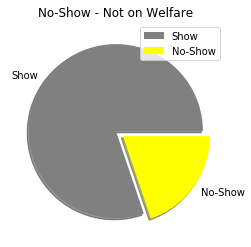

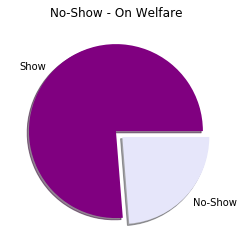

In [10]:
explode=[0,0.1]
plt.pie(no_welfare, labels = x_labels, colors=['gray', 'yellow'], explode=explode, shadow=True);
plt.legend()
plt.title('No-Show - Not on Welfare')
plt.show()
plt.pie(welfare, labels= x_labels, colors=['purple', 'lavender'], explode=explode, shadow=True);
plt.title('No-Show - On Welfare')
plt.show()

### Conclusion
My exploration in this dataset has led me to the following conclusions (**conclusions for this dataset only, not for the entire population**):
1. Younger Ages, around the age of 33, are more likely to be a no-show 
2. Gender does not play a role in whether a patient shows up 
3. Those who make appointments ahead of time are more likely to show up
4. If the patient is on welfare, there is a *slightly* higher likelihood that they will not show up. 

#### Considerations
I only explored a few variables in the dataset. For further analysis, it would be important to look at the relationship between Neighborhood and No-show, SMS-Received and No-show, etc. 

**Neighborhood and No-show**
The location of a single hospital in a particularly inconvenient, or run-down area could skew results. 

**SMS-Received and No-show**
Effect of receiving an SMS reminder regarding the appointment could be stronger than the relationships I explored above.

#### Further Steps
Next steps would include bootstrap sampling and hypothesis testing to obtain sufficient evidence in concluding whether the observations are statistically significant regarding the population. 